This notebook is to generate hisoric data for us to analyse in a seperate notebook
### To do:
- Add currency conversion
- Speed up the generator if possible

In [2]:
#Import the libraries
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import math
from datetime import timedelta 
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
import cvxpy as cp
#from joblib import Parallel, delayed
#Import our homebrew functions
import DatabaseMainFnc as dmf

pd.options.mode.chained_assignment = None #silences setting with a copy warning
pd.set_option('display.max_columns', 38)
plt.rcParams['figure.figsize'] = [15, 10]


## Load & Validate our price data

In [4]:
%%time
#Load database
df_Nasdaq=dmf.connectAndLoadDb('NASDAQ')

#Set date as index
df_Nasdaq=df_Nasdaq.set_index(pd.DatetimeIndex(df_Nasdaq['Date'].values))
df_Nasdaq.drop(columns=['Date'],axis=1, inplace=True)

#Validate the data 
dmf.priceDB_validation(df_Nasdaq)

#Do currency conversion here, we want USD in EUR out
#df_Nasdaq=load_curr_csv(df_Nasdaq,"USD")

df_Nasdaq.tail(5)

Connecting database:NASDAQ
Database connected!
---------------------------------------------------------------------
Negative prices are seen in the following assets: 1
['ITRN']
The following columns have been dropped: 
['ITRN']
Wall time: 4.57 s


,AACG,AACQ,AACQU,AAL,AAME,AAOI,AAON,AAPL,AAWW,AAXJ,ABCB,ABCL,ABCM,ABEO,ABGI,ABIO,ABMD,ABNB,ABST,...,ZIONO,ZIONP,ZIOP,ZIXI,ZKIN,ZLAB,ZM,ZNGA,ZNTE,ZNTEU,ZNTEW,ZNTL,ZS,ZSAN,ZUMZ,ZVO,ZWRKU,ZYNE,ZYXI
2021-04-01,4.19,10.32,10.770,23.860001,4.00,8.82,70.870003,123.000000,61.230000,93.709999,53.240002,30.709999,19.760000,1.86,9.90,3.76,315.339996,188.240005,13.99,...,27.920000,25.299999,3.63,7.74,9.83,130.960007,326.230011,10.48,10.00,10.62,1.26,43.340000,175.770004,1.23,43.500000,4.20,10.00,4.78,15.43
2021-04-05,4.20,10.23,10.830,24.230000,4.02,8.69,70.839996,125.900002,62.630001,93.970001,53.279999,28.090000,19.889999,1.85,9.94,3.67,321.500000,186.690002,13.88,...,27.530001,24.989799,3.67,7.81,9.34,125.110001,323.959991,10.66,10.05,10.65,1.29,43.750000,175.190002,1.24,43.299999,3.66,10.00,4.67,15.38
2021-04-06,3.99,10.18,10.757,24.059999,4.03,8.47,70.550003,126.209999,64.209999,94.559998,52.869999,29.000000,19.690001,1.70,9.94,3.66,323.619995,190.029999,14.21,...,27.650000,25.100000,3.42,7.75,8.93,127.690002,329.790009,10.54,10.03,10.64,1.35,43.040001,182.119995,1.27,43.790001,3.66,10.00,4.48,15.29
2021-04-07,3.99,10.30,10.870,23.930000,3.75,8.48,68.919998,127.900002,61.730000,92.980003,51.930000,31.290001,19.660000,1.62,9.92,3.63,320.619995,179.940002,14.10,...,27.590000,24.913799,3.38,7.51,7.75,135.279999,323.079987,10.55,10.07,10.75,1.30,41.070000,180.020004,1.21,44.389999,3.47,10.06,4.35,14.78
2021-04-08,4.06,10.39,11.050,23.650000,3.98,8.41,68.699997,130.360001,61.799999,93.930000,51.470001,30.590000,19.700001,1.67,9.92,3.61,329.750000,180.179993,14.41,...,27.610001,25.098499,3.39,7.66,7.77,132.880005,331.279999,10.68,10.08,10.70,1.36,42.459999,185.190002,1.22,45.310001,3.61,10.03,4.28,15.25


## Demonstrate the generator fuction with info displayed

Running for :2009-07-01 00:00:00 to 2015-04-01 00:00:00
Initial number of stocks: 4018
-----------------------------------------------------
Our max price is : €250
Number of stocks to drop due being unnaffordble: 74
Number of stocks remaining: 3944
-----------------------------------------------------
Number of stocks due to NAs: 2276
Number of stocks remaining: 1668
-----------------------------------------------------
Number of stocks due to being delisted: 2
Number of stocks remaining: 1666
-----------------------------------------------------
Number of stocks due to Negative returns: 292
Number of stocks remaining: 1374
Number of days data: 1449
As default we will only keep the top 50 performing stocks when creating our portfolio(this can be varied using s_asset & asset_len)
-------------------------------------------------------------
Our Benchmark portfolio the S&P 500 has: Volatility  18.1% & Annual Return: 10.6%
Expected annual return: 39.0%
Annual volatility: 12.8%
Sharpe Rat

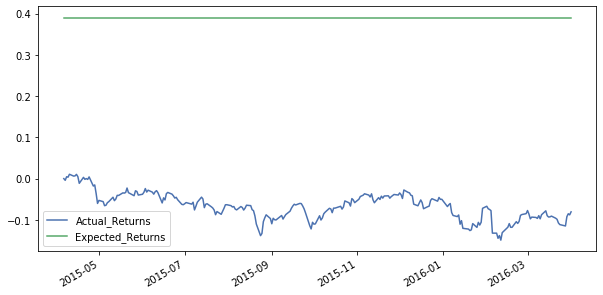

-------------------------------------------------------------
Our portfolio performed at : -8.0%
Max : 1.1%, Min : -14.9%, Mean : -6.7%
Wall time: 598 ms


[Timestamp('2009-07-01 00:00:00'),
 Timestamp('2015-04-01 00:00:00'),
 0.390156484534844,
 0.12786114719989736,
 2.894987982206538,
 0.010563950887667373,
 -0.1490331004545622,
 -0.08048635059549225,
 -0.06665695362424895,
 'SHARPE']

In [9]:
%%time
database=df_Nasdaq
startdate=pd.to_datetime("2009-07-01")
enddate=pd.to_datetime("2015-04-01")
dmf.portfolio_generate_test(database,startdate,enddate,p_max=250, min_returns=0.01, s_asset=100, asset_len=50, silent=False, obj_method="SHARPE")

In [8]:
%%time
#set or inputs & create empty lists for output
database=df_Nasdaq

#vary start date but beware its an N! problem need to speed this up if we can
startdate=pd.to_datetime("2017-01-01")
enddate=pd.to_datetime("2020-01-01")
a_test=[]
col_s_assets=[]
t_start=startdate
t_end=enddate

#vary start asset 0 takes the top 50 assets , 50 takes 50-99,.... this is an N problem which isnt too bad
l_s_asset=np.arange(0,50,50)


# example code that may also work for speeding this up rates_df[curr]=Parallel(n_jobs=-1)(delayed(get_rate)(curr,'EUR', date) for date in dates)
# runnings through starting assets, as we create portfolios for only 50 assets at a time (this can be varied)
for strt in l_s_asset: 
    t_start=startdate
    t_end=enddate
    print('Running for s_asset : '+ str(strt))

    # iterates through start dates by adding one month each time until theres 1 year between the start & end date
    while t_start + pd.DateOffset(years=1) <= t_end:
        a_test.append(portfolio_generate_test(database,t_start,t_end,s_asset=strt,asset_len=50))
        col_s_assets.append(strt)
        t_start=t_start + pd.DateOffset(months=1)

        #when our start date is 1 year from the end date subtract 1 year from the enddate & reset the start date
        if t_start + pd.DateOffset(years=1) == t_end:
            t_start=startdate
            t_end=t_end - pd.DateOffset(months=1)

#put all this data in a pandas datafame and save it             
df_test=pd.DataFrame(a_test,columns=['Start_Date','End_date','Expected_returns','volatility', 'sharpe_ratio','max_returns', 'min_returns', 'actual_returns','mean_returns','objective_summary'])
df_test['starting_asset']=col_s_assets
df_test.to_csv('Nasdaq_Performance_data.csv')

Running for s_asset : 0
C:\Users\patri\AppData\Local\Continuum\anaconda3\lib\site-packages\pypfopt\risk_models.py:69: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  "The covariance matrix is non positive semidefinite. Amending eigenvalues."
C:\Users\patri\AppData\Local\Continuum\anaconda3\lib\site-packages\pypfopt\risk_models.py:88: UserWarning: Could not fix matrix. Please try a different risk model.
  "Could not fix matrix. Please try a different risk model.", UserWarning
Wall time: 38 s


## Preview our data , more detailed analysis will be done in a seperate notebook

In [56]:
print("Actual returns should be >= -1, we have : "+str(df_test['actual_returns'].min())+str(df_test['min_returns'].min()))
df_test.tail(3)

Actual returns should be >= -1, we have : -0.29551362198972997-1.0


,Start_Date,End_date,Expected_returns,volatility,sharpe_ratio,max_returns,min_returns,actual_returns,mean_returns,starting_asset
298,2017-02-01,2018-03-01,4.356517,0.201902,21.478354,0.112564,-1.0,-0.145515,-0.074504,0
299,2017-01-01,2018-02-01,4.157828,0.182484,22.674970,0.252592,-1.0,-0.168076,0.018429,0
300,2017-01-01,2018-01-01,4.363201,0.169768,25.583142,0.291767,-1.0,-0.186892,0.053121,0


(-1, 6)

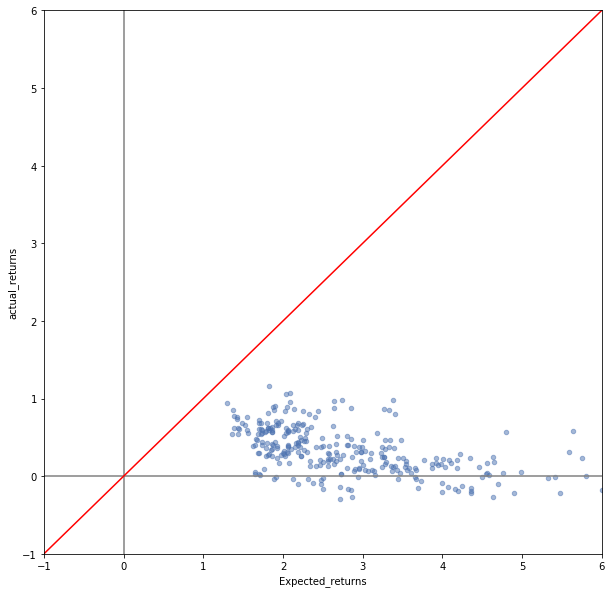

In [57]:
# Plot expected vs actual scatter
import matplotlib.lines as mlines
ax1 = df_test.plot.scatter(x='Expected_returns', y='actual_returns',alpha=0.5)

#set the x=y line
line = mlines.Line2D([0, 1], [0, 1], color='red')

#draw axis lines
plt.axhline(0,color='gray') # x = 0
plt.axvline(0,color='gray') # y = 0
transform = ax1.transAxes
line.set_transform(transform)
ax1.add_line(line)
ax1.set_xlim([-1, 6])
ax1.set_ylim([-1, 6])

(-1, 6)

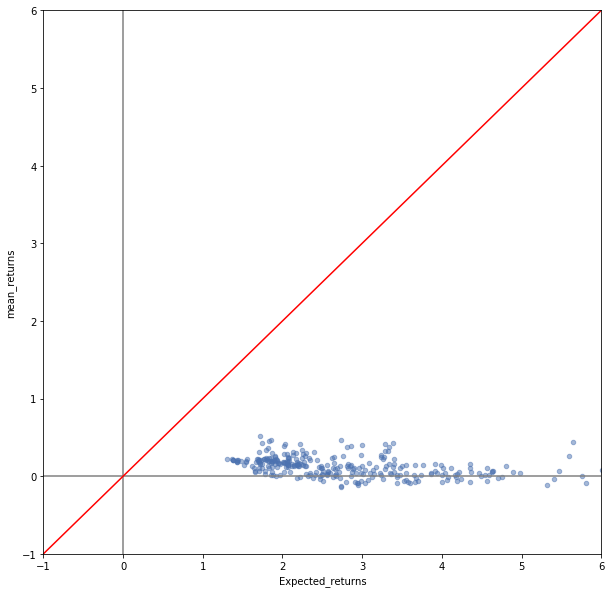

In [60]:
# Plot mean returns
import matplotlib.lines as mlines
ax1 = df_test.plot.scatter(x='Expected_returns', y='mean_returns',alpha=0.5)

#set the x=y line
line = mlines.Line2D([0, 1], [0, 1], color='red')

#draw axis lines
plt.axhline(0,color='gray') # x = 0
plt.axvline(0,color='gray') # y = 0
transform = ax1.transAxes
line.set_transform(transform)
ax1.add_line(line)
ax1.set_xlim([-1, 6])
ax1.set_ylim([-1, 6])

(-1, 6)

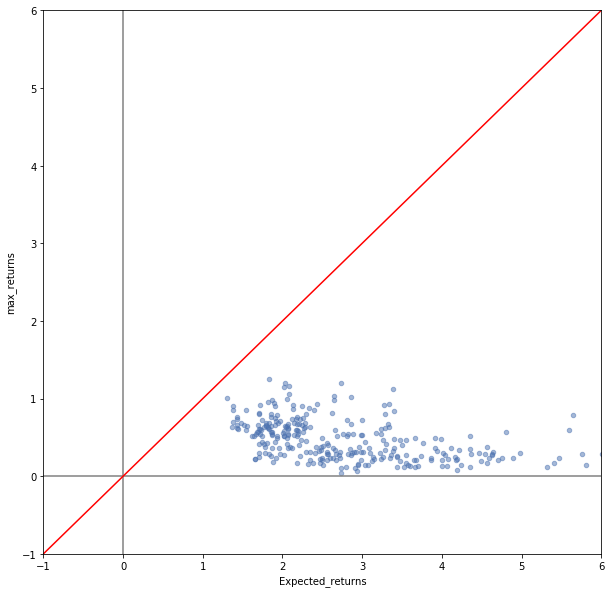

In [58]:
#show max peformance
ax1 = df_test.plot.scatter(x='Expected_returns', y='max_returns',alpha=0.5)

#set the x=y line
line = mlines.Line2D([0, 1], [0, 1], color='red')

#draw axis lines
plt.axhline(0,color='gray') # x = 0
plt.axvline(0,color='gray') # y = 0
transform = ax1.transAxes
line.set_transform(transform)
ax1.add_line(line)
ax1.set_xlim([-1, 6])
ax1.set_ylim([-1, 6])



(-1, 6)

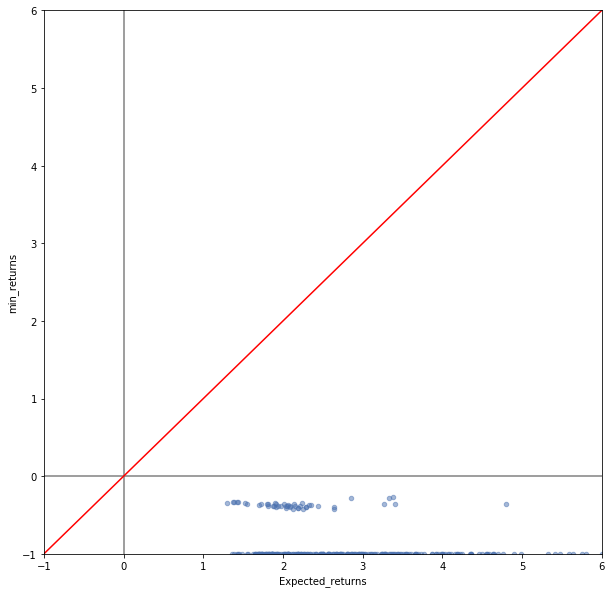

In [59]:
#show min peformance
ax1 = df_test.plot.scatter(x='Expected_returns', y='min_returns',alpha=0.5)

#set the x=y line
line = mlines.Line2D([0, 1], [0, 1], color='red')

#draw axis lines
plt.axhline(0,color='gray') # x = 0
plt.axvline(0,color='gray') # y = 0
transform = ax1.transAxes
line.set_transform(transform)
ax1.add_line(line)
ax1.set_xlim([-1, 6])
ax1.set_ylim([-1, 6])

### legacy code for reference
def portfolio_generate_test(database,startdate,enddate,p_max=400, min_returns=0.01, s_asset=0, asset_len=50,  silent=True):
    if silent == False:
        print('Running for :'+str(startdate)+' to '+str(enddate))
    # Subset for date range
    df_input=database[startdate:enddate]
    if silent == False:
        print ("Initial number of stocks: "+str(len(df_input.columns)))

    #Check for stocks which are too expensive for us to buy & drop those
    p_now=database.iloc[-1,:]
    df_unaffordable=p_now[p_now>p_max] #we can set max price here maybe as an optional
    l_unaffordable=df_unaffordable.index.tolist()
    df_input.drop(columns=l_unaffordable, inplace=True)
    if silent == False:
        print ("-----------------------------------------------------")
        print ("Our max price is : €"+str(p_max))
        print ("Number of stocks to drop due being unnaffordble: "+str(len(l_unaffordable)))
        print ("Number of stocks remaining: "+str(len(df_input.columns)))


    # drop any columns with more than half or more Nas as the models dont like these
    half_length=int(len(df_input)*0.50)
    l_drop=df_input.columns[df_input.iloc[:half_length,:].isna().all()].tolist()
    df_input.drop(columns=l_drop, inplace=True)
    if silent == False:
        print ("-----------------------------------------------------")
        print ("Number of stocks due to NAs: "+str(len(l_drop)))
        print ("Number of stocks remaining: "+str(len(df_input.columns)))

    # drop any columns with more  Nas for their last 5 rows as these have been delisted
    l_drop=df_input.columns[df_input.iloc[-5:,:].isna().all()].tolist()
    df_input.drop(columns=l_drop, inplace=True)
    if silent == False:
        print ("-----------------------------------------------------")
        print ("Number of stocks due to being delisted: "+str(len(l_drop)))
        print ("Number of stocks remaining: "+str(len(df_input.columns)))


    #see which stocks have negative returns or low returns in the period & drop those
    df_pct=(df_input.iloc[-1,:].fillna(0) / df_input.iloc[0,:])
    df_pct=df_pct[df_pct<= (min_returns + 1)] #we can set minimum returns here maybe as an optional
    l_pct=df_pct.index.tolist()
    df_input.drop(columns=l_pct, inplace=True)
    if silent == False:
        print ("-----------------------------------------------------")
        print ("Number of stocks due to Negative returns: "+str(len(l_pct)))
        print ("Number of stocks remaining: "+str(len(df_input.columns)))
        print ("Number of days data: "+str(len(df_input)))
        print ("As default we will only keep the top 50 performing stocks when creating our portfolio(this can be varied using s_asset & asset_len)")

    #We will only keep the X best performing assets can make this an optional input
    e_asset=s_asset + asset_len
    df=df_input
    mu = expected_returns.mean_historical_return(df)
    top_stocks = mu.sort_values(ascending=False).index[s_asset:e_asset]
    df = df[top_stocks]

    #Calculate expected annulised returns & annual sample covariance matrix of the daily asset
    mu = expected_returns.mean_historical_return(df)
    S = risk_models.sample_cov(df)

    # Optomise for maximal Sharpe ratio
    ef= EfficientFrontier(mu, S) #Create the Efficient Frontier Object

    #We can try a variety of objectives look at adding this as an input
    weights = ef.max_sharpe()
    #weights = ef.min_volatility()
    #target_volatility=0.1
    #weights = ef.efficient_risk(target_volatility)
    #target_return=0.1
    #weights = ef.efficient_return(target_return)


    cl_weights= ef.clean_weights()
    #print(cl_weights)
    if silent == False:
        print("-------------------------------------------------------------")
        print("Our Benchmark portfolio the S&P 500 has: Volatility  18.1% & Annual Return: 10.6%")
        ef.portfolio_performance(verbose=True)
    expected_portfolio_returns=ef.portfolio_performance()[0]
    volatility=ef.portfolio_performance()[1]
    r_sharpe=ef.portfolio_performance()[2]

    #calculates the actual performance date range work on this
    actual_startdate = pd.to_datetime(enddate) + pd.DateOffset(days=2)
    actual_enddate = pd.to_datetime(actual_startdate) + pd.DateOffset(years=1)

    df_actual=database[actual_startdate:actual_enddate]
    df_actual=df_actual[top_stocks]
    df_yoy=pd.DataFrame(df_actual.iloc[-1,:].fillna(0) / df_actual.iloc[0,:], columns=['yoy_perc'])
    df_yoy['weights']=cl_weights.values()
    df_yoy['weighted_perc']=df_yoy['weights']*df_yoy['yoy_perc']

    #for error checking
    #print(df_actual.iloc[-1,:].fillna(0))
    #print(df_actual.iloc[0,:])
    #print(df_yoy)

    actual_returns=df_yoy['weighted_perc'].sum()-1
    if silent == False:
        print("-------------------------------------------------------------")
        print("Our portfolio performed at : " + str(np.round(actual_returns,3)*100)+"%")
    return [pd.to_datetime(startdate), pd.to_datetime(enddate), expected_portfolio_returns, volatility, r_sharpe, actual_returns]